In [1]:
'''
   Scott Meyer
   
   Calculating Niño 3 index, Oceanic Niño Index (ONI),
   and Trans Niño Index (TNI) time series data that
   extends back through the nineteenth century since available
   public data starts at or near 1950 and to create ENSO indices
   data that uses the same SST dataset (ERSST) that I use. 
   Used in my El Nino Southern Oscillation (ENSO) research 
   to compare available US precipitation data that extends back 
   past 1950 as well as to have consistent sea surface temperature 
   (SST) index data that uses the same SST dataset.
'''

#For plotting figures below cell
%matplotlib inline 
#import rest of packages
import datetime as dt
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import csv as csv
import pandas as pd

In [2]:
ENSOdir  = "C:\\Users\\Owner\\Documents\\python_dir\\ENSO\\"
ERSST    = ENSOdir + "ERSST\\sst.mnmean_updated.nc"

In [3]:
'''
   "ncdump" function to make .nc data information more readable

    Source: Chris Slocum
        http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html
'''

def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.   
    
    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim)
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [4]:
''' 
    Recieved from Dr. John Nielsen-Gammon
    
    Define new class to extract gridded longitude and
    latitude indices for particular gridded, global 
    oceanic or atmospheric datasets using bounds of 
    the desired region. Accounts for differences
    in grid spacing among these datasets
    
    Input: Lat/Lon grid information
'''

class LatLon:
    def __init__(self,lat0=-90,dlat=1,nlat=181,lon0=0,dlon=1,nlon=360):
        self.lat0 = lat0
        self.dlat = dlat
        self.nlat = nlat
        self.lon0 = lon0
        self.dlon = dlon
        self.nlon = nlon
        
    def il(self,i):
        lati = self.lat0 + self.dlat*i
        return lati
    
    def jl(self,j,w=True):
        loni = self.lon0 + self.dlon*j
        if w and loni > 180:
            loni = -(360 - loni)
        return loni
    
    def li(self,latval):
        i = int(round((latval-self.lat0)/self.dlat))
        if i < 0:
            i += self.nlat
        if i >= self.nlat:
            i += -self.nlat  
        return i

    def lj(self,lonval):
        j = int(round((lonval-self.lon0)/self.dlon))
        if j < 0:
            j += self.nlon
        if j >= self.nlon:
            j += -self.nlon
        return j
    
    def lltoij(self,latval,lonval):
        i = self.li(latval)
        j = self.lj(lonval)
        return i,j
    
    def latr(self,latval1,latval2):
        i1 = self.li(latval1)
        i2 = self.li(latval2)
        ist = min(i1,i2)
        ien = ist + abs(i2-i1) + 1
        return ist,ien
    
    def lonr(self,lonval1,lonval2):
        j1 = self.lj(lonval1)
        j2 = self.lj(lonval2)
        jst = min(j1,j2)
        jen = jst + abs(j2-j1) + 1
        return jst,jen

In [5]:
''' Load in SST data and ncdump of ERSST data '''

SST_nc = Dataset(ERSST,'r') #reads in the data
nc_attrs,nc_dims,nc_vars = ncdump(SST_nc)

NetCDF Global Attributes:
	climatology: 'Climatology is based on 1971-2000 SST, Xue, Y., T. M. Smith, and R. W. Reynolds, 2003: Interdecadal changes of 30-yr SST normals during 1871.2000. Journal of Climate, 16, 1601-1612.'
	description: 'In situ data: ICOADS2.5 before 2007 and NCEP in situ data from 2008 to present. Ice data: HadISST ice before 2010 and NCEP ice after 2010.'
	keywords_vocabulary: 'NASA Global Change Master Directory (GCMD) Science Keywords'
	keywords: 'Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature >'
	instrument: 'Conventional thermometers'
	source_comment: 'SSTs were observed by conventional thermometers in Buckets (insulated or un-insulated canvas and wooded buckets) or Engine Room Intaker'
	geospatial_lon_min: -1.0
	geospatial_lon_max: 359.0
	geospatial_laty_max: 89.0
	geospatial_laty_min: -89.0
	geospatial_lat_max: 89.0
	geospatial_lat_min: -89.0
	geospatial_lat_units: 'degrees_north'
	geospatial_lon_units: 'degrees_east'
	cdm_data_type: 'Gr

In [6]:
''' Load in SST data variables'''
SSTlats = SST_nc.variables['lat'][:]  # extract/copy the data
SSTlons = SST_nc.variables['lon'][:] 
SSTtime = SST_nc.variables['time'][:]
SST = SST_nc.variables['sst'][:]  # shape is time, lat, lon as shown above.
SSTdtime = num2date(SST_nc.variables['time'][:],SST_nc.variables['time'].units)
SSTnyears = SSTdtime[-1].year-SSTdtime[0].year

SSTll = LatLon(SSTlats[0],SSTlats[1]-SSTlats[0],
                 SST_nc.variables['lat'].size,
                 SSTlons[0],SSTlons[1]-SSTlons[0],
                 SST_nc.variables['lon'].size)

In [7]:
'''
   Create SSTdtime as a pandas date range to make it easy
   to index and plot data. Makes it a DateTimeIndex rather than
   a Masked Array. 
'''
#Spans from 01/1854 to 10/2021
#freq = 1m uses end dates of month, MS uses start dates of month
SSTdtime_pd = pd.date_range('1854-01-01', '2021-10-01', freq='MS')

In [8]:
''' 
    Calculating Niño 1+2, Niño 3, Niño 3.4 and Niño 4
    monthly mean using ERSST data

    Part 1: 
    Find gridpoint index bounds to retrieve monthly
    values for each Niño index for averaging.
'''

#New monthly SST dataset that converts 
#land values that are set to be missing
#values to NaN's for calculation of
#monthly box means
SST_nino = np.copy(SST)
SST_nino[SST_nino <= -1e+36] = np.nan

#Nino 1+2 box bounds: 0°-10°S,90°W-80°W
latr_nino12 = SSTll.latr(0,-10) 
lonr_nino12 = SSTll.lonr(-90,-80) 

#Niño 3 box bounds: 5°N-5°S,150°W-90°W
latr_nino3 = SSTll.latr(5,-5) 
lonr_nino3 = SSTll.lonr(-150,-90) 

#Niño 3.4 box bounds: 5°N-5°S, 170°W-120°W
latr_nino3pt4 = SSTll.latr(5,-5)
lonr_nino3pt4 = SSTll.lonr(-170,-120) 

#Niño 4 box bounds: 5°N-5°S,160°E-150°W
latr_nino4 = SSTll.latr(5,-5)
lonr_nino4 = SSTll.lonr(160,-150)         

In [9]:
'''
   NOTE: np.copy automatically converts the missing values in SST that
         cover land to missing values as displayed in ERSST NetCDF file 
         information (-9.96e+36). Mean function works with the original 
         imported data. Demonstration below.
'''
print('Min SST copied version:',np.min(SST_nino))
print('Min SST original version:',np.min(SST))

#covers the United States and part of the Gulf of Mexico
#to retrieve grid points over land and over the ocean
latr_test = SSTll.latr(30,36)
lonr_test = SSTll.lonr(-90,-78)

#using first month as data to demonstrate
SST_copy = SST_nino[0,latr_test[0]:latr_test[1],lonr_test[0]:lonr_test[1]]
SST_original = SST[0,latr_test[0]:latr_test[1],lonr_test[0]:lonr_test[1]]
print('\n','Extracted SSTs using np.copy with NaNs','\n')
print(SST_copy)
print('\n','Extracted SSTs from NetCDF file','\n')
print(SST_original)

print('\n','Mean SST using np.copy:',np.round(np.nanmean(SST_copy),3),'°C')
print(' Mean SST from NetCDF file:',np.round(np.mean(SST_original),3),'°C')

Min SST copied version: nan
Min SST original version: -1.8

 Extracted SSTs using np.copy with NaNs 

[[      nan       nan       nan       nan       nan       nan       nan]
 [      nan       nan       nan       nan       nan       nan 21.631266]
 [      nan       nan       nan       nan       nan 22.75975  23.008121]
 [20.442669 20.670347 20.519907 20.471272       nan 23.314177 23.791952]]

 Extracted SSTs from NetCDF file 

[[-- -- -- -- -- -- --]
 [-- -- -- -- -- -- 21.63126564025879]
 [-- -- -- -- -- 22.759750366210938 23.008121490478516]
 [20.442668914794922 20.670347213745117 20.519906997680664
  20.471271514892578 -- 23.314176559448242 23.79195213317871]]

 Mean SST using np.copy: 21.845 °C
 Mean SST from NetCDF file: 21.845 °C


C:\Users\Owner\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [10]:
'''
   Create function to trim SST gridpoints on boundary
   edges to match size of official Niño box bounds. 
   Method used to find monthly mean of SSTs for each Niño box 
   that make adjustments to directly match bounds of Niño boxes.
'''

'''Description'''
#Divide edge of grid SST values for longitude by 2. Since grid point represents single value
#for SSTs across the 2° by 2° grid box domain and are centered, divide the grid box by 2 at the
#longitude grid bounds on the west and east side of the box to represent a single SST value.
#This will adjust values so that represented longitude values at both boundaries
#represent the exact boundaries of each Niño box (e.g. gridpoint at -120°W will cover from 
#-121°W to -120°W for this purpose rather than -121°W to -119°W to match Niño 3.4 SST box definition)

def nino_box_trim(nino_box_data):
    #trim using method discussed above to retrieve effective values that match the Niño box size
    #based on the grid spacing. Do step wise with for loop for each month

        #First, divide outer grid points on west/east edges by 2
        nino_box_trim_west_edge = nino_box_data[:,0]/2
        nino_box_trim_east_edge = nino_box_data[:,-1]/2
        #create new array to place all desired values in
        nino_box_trim_arr = np.zeros((nino_box_data.shape[0],nino_box_data.shape[1]))
        nino_box_trim_arr[:,0] = nino_box_trim_west_edge #adjusted values
        nino_box_trim_arr[:,1:-1] = nino_box_data[:,1:-1] #normal values (do not need to be adjusted)
        nino_box_trim_arr[:,-1] = nino_box_trim_east_edge #adjusted values
        
        #using remainder function to trim Niño 1+2 box since it is the only
        #Niño box that has even amount of gridpoints and needs to be trimmed
        #on northern and southern borders. 
        
        #Note: This function works for the purpose I need it for.
        #if I am calculating more boxes and there is a box with
        #even (odd) amount of grid points that does not (does) need
        #to be trimmed, I need to adjust the definition to import box
        #indices to compare with box edge grid points and revise the
        #function
        if nino_box_data.shape[0] % 2 == 0:
            nino_box_trim_n_edge = nino_box_data[0,:]/2
            nino_box_trim_s_edge = nino_box_data[-1,:]/2
            
            nino_box_trim_arr[0,:] = nino_box_trim_n_edge
            nino_box_trim_arr[-1,:] = nino_box_trim_s_edge
              
        #take monthly mean of nino box manually to take into account for the amount of 
        #effective Niño box grid points since I'm halving the gridpoints values on the 
        #edges that I adjust
        
        #Note: add one to the number of gridpoints for box trim of Nino 1+2
        #since there is a NaN value at the eastern edge of extracted values.
        #Does not count as trimmed grid value. Another area I would revise
        #if more SST boxes that cover land areas needed to be calculated
        if nino_box_data.shape[0] %2 == 0:
            num_nino_box_gpoints = nino_box_data.shape[0]*nino_box_data.shape[1]
            adj_num_gpoints = num_nino_box_gpoints - nino_box_data.shape[1] - nino_box_data.shape[0] + 1
            nino_box_mean = np.nansum(nino_box_trim_arr)/(adj_num_gpoints)
        else:
            num_nino_box_gpoints = nino_box_data.shape[0]*nino_box_data.shape[1]
            nino_box_mean = np.sum(nino_box_trim_arr)/(num_nino_box_gpoints - nino_box_data.shape[0])

        return(nino_box_mean)

In [11]:
'''
    Part 2: Find monthly SST mean values for each
    Niño box. Then, reshape array to be year by month to 
    average running 30 year means for Nino 3 index and
    Oceanic Niño Index.
'''

#No. of months in ERSST data
month_count = len(SSTtime)

#Empty arrays for the for loop
nino12monthly = np.zeros((month_count,))
nino3monthly = np.zeros((month_count,))
nino3pt4monthly = np.zeros((month_count,))
nino4monthly = np.zeros((month_count,))

for month in range(month_count):
        nino12monthly_gpoints = SST_nino[month,latr_nino12[0]:latr_nino12[1],
                                                    lonr_nino12[0]:lonr_nino12[1]]
        nino12_trim = nino_box_trim(nino12monthly_gpoints)
        nino12monthly[month] = nino12_trim
        
        nino3monthly_gpoints = SST_nino[month,latr_nino3[0]:latr_nino3[1],
                                                    lonr_nino3[0]:lonr_nino3[1]]
        nino3_trim = nino_box_trim(nino3monthly_gpoints)
        nino3monthly[month] = nino3_trim
   
        nino3pt4monthly_gpoints = SST_nino[month,latr_nino3pt4[0]:latr_nino3pt4[1],
                                           lonr_nino3pt4[0]:lonr_nino3pt4[1]]
        nino3pt4_trim = nino_box_trim(nino3pt4monthly_gpoints)
        nino3pt4monthly[month] = nino3pt4_trim
        
        
        nino4monthly_gpoints = SST_nino[month,latr_nino4[0]:latr_nino4[1],
                                                    lonr_nino4[0]:lonr_nino4[1]]
        nino4_trim = nino_box_trim(nino4monthly_gpoints)
        nino4monthly[month] = nino4_trim

'''Reshape monthly nino SST averages'''

#subtract by 1 so it goes through 2020 (using upd. ERSST data)
#omit 2021 data since it does not span the full year
year_count_ersst = int(np.round(month_count/12,0)) - 1 

#reshaping arrays to year by months in year (12) using year_count_ersst
#Note: remove jan-oct 2021 Nino SST box values for reshaping purposes 
#(use later to calculate 2021 ind vals)

nino12monthly_ym = nino12monthly[0:month_count-10].reshape(year_count_ersst,12)
nino3monthly_ym = nino3monthly[0:month_count-10].reshape(year_count_ersst,12)
nino3pt4monthly_ym = nino3pt4monthly[0:month_count-10].reshape(year_count_ersst,12)
nino4monthly_ym = nino4monthly[0:month_count-10].reshape(year_count_ersst,12)

In [12]:
''' 
    Part 3: Calculate 30 year SST means for all periods starting from January 
            1876. (Jan1876-Dec1905,Jan1881-Dec1910,Jan1886-Dec1915...
            Jan1991-Dec2020) for Niño 3 index and ONI data.TNI data uses a 
            set time period for anomaly calculations. 30 year means are 
            calculated using monthly means for each 30 year period. (e.g,
            January (February) 1951-1955 anomalies are calculated using
            January (February) 30 year SST mean from 1936-1965).
            
    Note: ONI uses Niño 3.4 SST box.
'''

#number of thiry year periods, since each period starts at 5 year inc. from Jan1881 to Dec2015
#Note: last 30 year period starts on January of 1991, so that's the last number in equation 
#to be accounted for to calculate the number of thirty year means. (Jan 1991 to Dec 2020 is last one)
#add 1 so that 1991-2020 period is calculated
thirty_yr_period_count = np.arange(1876,1991,5).shape[0] + 1 

#Find start year idx for 30 year mean calculations, 
#which is start year for 30 year averages minus start year ersst data
yr_start_30yr_means_idx = int(np.where(SSTdtime_pd == '1876-01-01')[0]/12)

#find month/year index value for full SST data set that corresponds to beginning of 1991
SST_ind_1991_monthly = np.where(SSTdtime_pd == '1991-01-01')[0]
yr_start_for_final_30yr_mean_idx = int(SST_ind_1991_monthly/12)


#empty array used in for loop
nino3_30yr_means = np.zeros((thirty_yr_period_count,12))
nino3pt4_30yr_means = np.zeros((thirty_yr_period_count,12))

#array for Niño means (monthly) will be thirty year mean calc number 
#(starting at 1876 to 1905 to 1991-2020) by month
#[0,:] = 1871 to 1905 mean. [1,:] = 1881 to 1910 mean,....

#first for loop shifts indexing every 5 years up to 1991avg
#Indexes every 5 yrs.
for count in range(yr_start_30yr_means_idx,yr_start_for_final_30yr_mean_idx+5,5):
    #idx to store 30 year means for each month into pre-set array
    idx_store = int(np.round(count/5,0)) - 4
    for month in range(12):
        nino3_30yr_means[idx_store,month] = np.mean(nino3monthly_ym[count:count+30,month])
        nino3pt4_30yr_means[idx_store,month] = np.mean(nino3pt4monthly_ym[count:count+30,month])        

In [13]:
'''
    Part 4: Calculate SST monthly anomaly value for Niño 3
    and 3.4 box. Data calculations start at 01/1891 and 
    end at 12/2020.
'''

#Note: According to Climate Prediction Center,
#1951-1955 monthly Niño box anomalies calculated using
#the centered mean of 1936-1965
#1996-2000 would use centered mean of 1981-2010
#Mean becomes non-centered after the period of
#2006-2010, so 2011-2021 uses 1991-2020 mean


#want data calculations to start at 01/1891
SST_ind_1891_monthly = np.where(SSTdtime_pd == '1891-01-01') 
start_year_ind = int(SST_ind_1891_monthly[0]/12) 


#Index last year period to use centered averages before switching to using 1991-2010 mean for rest of values
SST_ind_2006_monthly = np.where(SSTdtime_pd == '2006-01-01')
ind_non_centered_avgs = int(SST_ind_2006_monthly[0]/12)

#arrays for storing calculations in for loop
nino3monthly_anom = np.zeros((year_count_ersst-start_year_ind,12))
nino3pt4monthly_anom = np.zeros((year_count_ersst-start_year_ind,12))

'''
   Calculate monthly anomalies for each Niño box using
   the monthly 
'''
for year in range(start_year_ind,year_count_ersst,5):
    #indexing proper mean to subtract for anomaly values
    loop_count = int(np.round(year/5)) - 7
    mean_idx = loop_count 
    #for monthly anomaly array storage
    array_ind = year - start_year_ind 
    for month in range(12):
        if year <= ind_non_centered_avgs:
            nino3monthly_anom[array_ind:array_ind+5,
                               month] = nino3monthly_ym[year:year+5,month] - nino3_30yr_means[mean_idx,month]
            nino3pt4monthly_anom[array_ind:array_ind+5,
                               month] = nino3pt4monthly_ym[year:year+5,month] - nino3pt4_30yr_means[mean_idx,month]
        elif year > ind_non_centered_avgs:
            nino3monthly_anom[array_ind:array_ind+5,
                               month] = nino3monthly_ym[year:year+5,month] - nino3_30yr_means[-1,month]
            nino3pt4monthly_anom[array_ind:array_ind+5,
                               month] = nino3pt4monthly_ym[year:year+5,month] - nino3pt4_30yr_means[-1,month]

In [14]:
'''
   Create operational index values. ONI uses 3 month running means and Niño 3 
   index using 5 month running means for monthly index value.
'''

#unroll the anomaly data so it's a vector of monthly values to use in for loop
array_shape = (year_count_ersst - start_year_ind)*12 #data from 1891 through 2020

nino3monthly_anom_vec = nino3monthly_anom.reshape(array_shape,)
nino3pt4monthly_anom_vec = nino3pt4monthly_anom.reshape(array_shape,)

#index calc. for DJF 1892 (ONI) and NDJFM 1892 (Nino 3 Index) first.
#Since indexing Jan 1892 and anomaly calculations start in Jan 1891,
#use idx = 12 (months)
start_ind = 12

#leave out last three months of data since Niño 3 Index uses 5 month running mean
#So index calculation goes through September being centered month (09/2020)
end_ind = array_shape - 2

#empty arrays for operational index values
oni_indvals = np.zeros((end_ind-start_ind,))
nino3_indvals = np.zeros((end_ind-start_ind,))

#calcs. up to JASON 2020 for Nino 3 index (ASO 2020 for ONI)
for month in range(start_ind,end_ind):
    oni_indvals[month-start_ind] = np.round(np.mean(nino3pt4monthly_anom_vec[month-1:month+2]),3)
    nino3_indvals[month-start_ind] = np.round(np.mean(nino3monthly_anom_vec[month-2:month+3]),3)

    
'''
   Calculate SON 2020-JFM 2021 index values for ONI and ASOND 
   2020-DJFMA 2020/2021 for Niño 3.
'''

#time bounds to use within for loop for rest of
#anomaly calculations
SST_ind_aug_2020 = np.where(SSTdtime_pd == '2020-08-01')
beg_ind = int(SST_ind_aug_2020[0])
SST_ind_may_2021 = np.where(SSTdtime_pd == '2021-05-01')
end_ind = int(SST_ind_may_2021[0])

nino3pt4_anom_2020 = np.zeros((end_ind-beg_ind,))
nino3_anom_2020 = np.zeros((end_ind-beg_ind,))
#pre-set array to find months index needed in 30yr_means to calculate anomaly vals.
month_array = np.array([7,8,9,10,11,0,1,2,3]) #Note: idx for August is 7 since indexing starts at 0 with python
for month in range(beg_ind,end_ind):
    ind = month-beg_ind
    ind_month = month_array[ind]
    
    nino3pt4_anom_2020[ind] = nino3pt4monthly[month] - nino3pt4_30yr_means[-1,ind_month]
    nino3_anom_2020[ind] = nino3monthly[month] - nino3_30yr_means[-1,ind_month]

#Last index values (technically goes through 2021)
oni_indvals_2020 = np.zeros((5,))
nino3_indvals_2020 = np.zeros((5,))

#ind Aug 2020 through Feb 2021 (center point of running mean)
for month in range(2,month_array.shape[0]-2): 
    #print(month_array[month]) #check to make sure indexing right months
    #Nino3pt4 uses 3 month running mean and Nino3 uses 5 month running mean
    #write for loops
    oni_indvals_2020[month-2] = np.round(np.mean(nino3pt4_anom_2020[month-1:month+2]),3)
    nino3_indvals_2020[month-2] = np.round(np.mean(nino3_anom_2020[month-2:month+3]),3)

In [15]:
'''
   Append ONI and Niño 3 index arrays from above 2 cells. 
   ONI and Niño 3 index start at Jan 1892 (e.g, DJF 1892 for ONI)
'''

#where I began calculating Nino indices values
start_year_ind_data_calcs = int(np.where(SSTdtime_pd == '1892-01-01')[0]/12) 
year_count_ersst_full = int(np.round(len(SSTtime)/12,0))

nino_inds_yr_len = year_count_ersst_full - start_year_ind_data_calcs
month_count_oni_indvals = oni_indvals.shape[0]

#where I began Nino indices calculation
idx_jan_1892 = int(np.where(SSTdtime_pd == '1892-01-01')[0]) 
#use this to extract values up to Dec. 2020 from oni_indvals
idx_jan_2020 = int(np.where(SSTdtime_pd == '2020-01-01')[0]) 

#use this index value to extract desired values through Dec 2019 into new array
idx_dec_2020 = idx_jan_2020 - idx_jan_1892

oni = np.zeros((nino_inds_yr_len,12))
nino3index = np.zeros((nino_inds_yr_len,12))

#create operational index values array that spans from Jan 1892 to Feb 2020
oni[0:nino_inds_yr_len-2,:] = oni_indvals[0:idx_dec_2020].reshape(nino_inds_yr_len-2,12) #DJF 1892-NDJ 2020
oni[nino_inds_yr_len-2,0:9] = oni_indvals[idx_dec_2020+1:idx_dec_2020+10] #DJF 2020-ASO 2020
#Note: put 9:12 so it places SON,OND,and NDJ 2020 in spots 9,10,11 (indexing nuance in python)
oni[nino_inds_yr_len-2,9:12] = oni_indvals_2020[0:3] #idx start is 1 due to recalculation of ASO in this array
oni[-1,0] = oni_indvals_2020[3] #DJF 2021
oni[-1,1] = oni_indvals_2020[4] #JFM 2021

oni_vector = oni.reshape([oni.shape[0]*oni.shape[1]])

nino3index[0:nino_inds_yr_len-2,:] = nino3_indvals[0:idx_dec_2020].reshape(nino_inds_yr_len-2,12)
nino3index[nino_inds_yr_len-2,0:9] = nino3_indvals[idx_dec_2020+1:idx_dec_2020+10]
nino3index[nino_inds_yr_len-2,9:12] = nino3_indvals_2020[0:3] 
nino3index[-1,0] = nino3_indvals_2020[3]
nino3index[-1,1] = nino3_indvals_2020[4] 

nino3index_vector = nino3index.reshape([nino3index.shape[0]*nino3index.shape[1]])

In [16]:
'''
   Compare ONI data from CPC to my version of the ONI.
   ONI data uses centered base periods for calculation when
   possible.
'''

#ONI data from CPC that spans from DJF 1950 to JFM 2021
filename_oni_cpc = ENSOdir + "ENSO_indices\\CPC_ONI_centered_base_periods.csv"

#below, I ignore first row of data (header info.) and extract last row of information (monthly operational index vals)
#I can comment out next(file) line and adjust (or remove) the column values I extract to see all of the data.
oni_cpc = []
with open(filename_oni_cpc, mode = 'r') as file:
    next(file) #skips first row in csv file for reading (if you want to include header info., comment this out)
    csvFile = csv.reader(file, delimiter = ',') 
    for row in csvFile: # each row is a list
        #since iterating over each row, I can index it with 3 to retrieve anomaly column.
        oni_cpc.append(row[3]) 

#temporal length of dataset
oni_cpc_ind_length = np.shape(oni_cpc) #perform this way to find shape of list (can't use oni_cpc.shape)

#converts all data contained in retrieved list to floats
oni_cpc_data_floats = [float(x) for x in oni_cpc]
#Have to convert data values in list to floats first to transform the data from list to array
oni_cpc_oper_data = np.asarray(oni_cpc_data_floats)
#check to make sure data length matches after conversions (it does)
oni_cpc_array_length = oni_cpc_oper_data.shape

In [17]:
'''
   Compare my calculated ONI, Niño 3.4 monthly anomaly 
   SST values and thirty year means used for ONI calculation 
   from CPC to my Niño 3.4 SST parameters.
'''

#ONI data from CPC that spans from Jan 1950 to March 2021
#Includes monthly mean SST, respective monthly 30 year average values, and monthly anomalies
filename_cpc_oni_calc_info = ENSOdir + "ENSO_indices/CPC_ONI_monthly_index_anomalies.csv"

nino3pt4_cpc_sst = []
nino3pt4_cpc_30yr_mean_info = []
nino3pt4_cpc_sst_anom = []
with open(filename_cpc_oni_calc_info, mode = 'r') as file:
    next(file) #skips first row in csv file for reading (if you want to include header info., comment this out)
    csvFile = csv.reader(file, delimiter = ',') 
    for row in csvFile: # each row is a list
        #to view all values, remove braces. Extracting Niño 3.4 monthly SST mean for comparison
        nino3pt4_cpc_sst.append(row[2])
        nino3pt4_cpc_30yr_mean_info.append(row[3])
        nino3pt4_cpc_sst_anom.append(row[4])

#converts all data contained in retrieved list to floats
nino3pt4_cpc_data_floats_sst = [float(x) for x in nino3pt4_cpc_sst]
nino3pt4_cpc_data_floats_30yr_mean_info = [float(x) for x in nino3pt4_cpc_30yr_mean_info]
nino3pt4_cpc_data_floats_sst_anom = [float(x) for x in nino3pt4_cpc_sst_anom]

#Convert data values in list to floats first to transform the data from list to array
nino3pt4_cpc_monthly_sst = np.asarray(nino3pt4_cpc_data_floats_sst)
nino3pt4_cpc_30yr_means = np.asarray(nino3pt4_cpc_data_floats_30yr_mean_info)
nino3pt4_cpc_monthly_sst_anom = np.asarray(nino3pt4_cpc_data_floats_sst_anom)    

#temporal length of dataset (monthly scale)
nino3pt4_cpc_data_length = nino3pt4_cpc_monthly_sst.shape[0]

'''Extract thirty year means to from CPC data for comparison'''
#reshape CPC array to be year x months
yr_reshape = int((nino3pt4_cpc_data_length-3)/12)
month_count = 12
cpc_oni_sst_means_ym = nino3pt4_cpc_30yr_means[0:nino3pt4_cpc_data_length-3].reshape(yr_reshape,month_count)

#preset array to place values in for loop
thirty_year_means_cpc = np.zeros((np.arange(1951,2006,5).shape[0]+1,12))

#so it extracts 30 year average for 1991-2020, which is first used in 2006
end_yr_idx = 2011-1950 
for year in range(1,end_yr_idx,5):
    idx_store = int(np.round(year/5))
    thirty_year_means_cpc[idx_store,:] = cpc_oni_sst_means_ym[year,:]

C:\Users\Owner\Anaconda3\lib\site-packages\matplotlib\legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


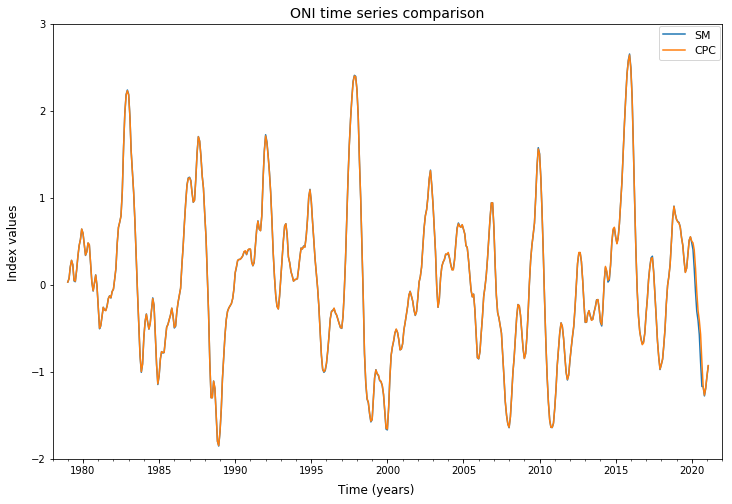

In [18]:
'''
    First, plot the difference between my ONI data and 
    Climate Prediction Center (CPC) data.
'''

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

#To use for time series calculation and my ONI indexing
start_ind_my_oni = int(np.where(SSTdtime_pd == '1892-01-01')[0])
start_ind_cpc = int(np.where(SSTdtime_pd == '1950-01-01')[0])

start_ind_plot = int(np.where(SSTdtime_pd == '1979-01-01')[0])
start_ind_cpc_compare = start_ind_plot - start_ind_my_oni

end_ind_plot = int(np.where(SSTdtime_pd == '2021-02-01')[0]) + 1
end_ind_cpc_compare = end_ind_plot - start_ind_my_oni

oni_sm_plot = oni_vector[start_ind_cpc_compare:end_ind_cpc_compare]

#To use for CPC ONI indexing
start_ind_cpc_oni = start_ind_plot - start_ind_cpc

oni_cpc_plot = oni_cpc_oper_data[start_ind_cpc_oni:]

legend_info = ['SM','CPC']
time_axis = SSTdtime_pd[start_ind_plot:end_ind_plot]

'''Plot data'''
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
sm_data = ax.plot(time_axis,oni_sm_plot)
cpc_data = ax.plot(time_axis,oni_cpc_plot)
plt.title('ONI time series comparison',fontsize = '14')

    
#set x-limit of plot with datetime
ax.set_xlim([dt.date(1978, 1, 1), dt.date(2022, 1, 1)])
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(5)) 
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) 

ax.set_ylim([-2,3])
ax.set_yticks(np.arange(-2,4,1))

# Set x and y labels
fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 12)
#legend
fig.legend([sm_data,cpc_data], labels=legend_info,
           bbox_to_anchor = (0.84,0.84),fontsize = 11)

In [19]:
'''Check for strength of relationship between re-created and public
   CPC ONI data.'''

print('Correlation of my ONI data and CPC ONI')
corr_data = np.corrcoef(oni_sm_plot,oni_cpc_oper_data[start_ind_cpc_oni:])[0,1]
corr_data_rounded = np.round(corr_data,4)
print(corr_data_rounded)

print('Correlation full ONI CPC data vs. my ONI (1950-2021)')
s_idx = start_ind_cpc - start_ind_my_oni
end_idx = end_ind_cpc_compare
corr_full_data = np.corrcoef(oni_vector[s_idx:end_idx],oni_cpc_oper_data)[0,1]
print(np.round(corr_full_data,4))

Correlation of my ONI data and CPC ONI
0.9995
Correlation full ONI CPC data vs. my ONI (1950-2021)
0.9996


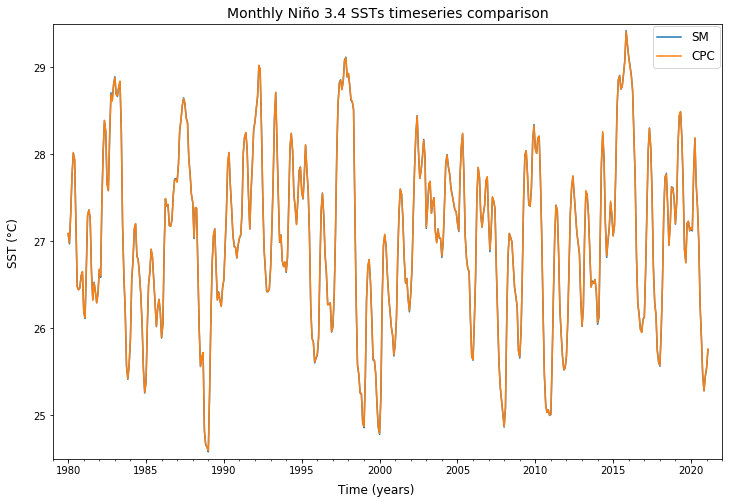

In [20]:
'''Plot timeseries of my Niño 3.4 monthly SSTs vs CPC's used for ONI.'''

#indexing for plotting
start_ind_plot = int(np.where(SSTdtime_pd == '1980-01-01')[0])
start_ind_cpc = int(np.where(SSTdtime_pd == '1950-01-01')[0])

start_ind_my_nino34 = start_ind_plot 
start_ind_cpc_nino34 = start_ind_plot - start_ind_cpc

end_ind = int(np.where(SSTdtime_pd == '2021-02-01')[0]) + 1
end_ind_my_nino34 = end_ind
end_ind_cpc_nino34 = end_ind - start_ind_cpc

#axis using date timestamps
time_axis = SSTdtime_pd[start_ind_plot:end_ind]
#legend
legend_info = ['SM','CPC']

#create figure
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
sm_data = ax.plot(time_axis,nino3pt4monthly[start_ind_my_nino34:end_ind_my_nino34])
cpc_data = ax.plot(time_axis,nino3pt4_cpc_monthly_sst[start_ind_cpc_nino34:end_ind_cpc_nino34])
plt.title('Monthly Niño 3.4 SSTs timeseries comparison',fontsize = '14')

ax.set_xlim([dt.date(1979, 1, 1), dt.date(2022, 1, 1)])
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(5)) #major tickmarks every 5 years
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) #minor tickmarks every year

ax.set_ylim([24.5,29.5])
ax.set_yticks(np.arange(25,30,1))

fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'SST (°C)', ha='center', va='center', rotation='vertical', fontsize = 12)
fig.legend([sm_data,cpc_data], labels=legend_info,
           bbox_to_anchor =(0.84, 0.84),fontsize = 12) 

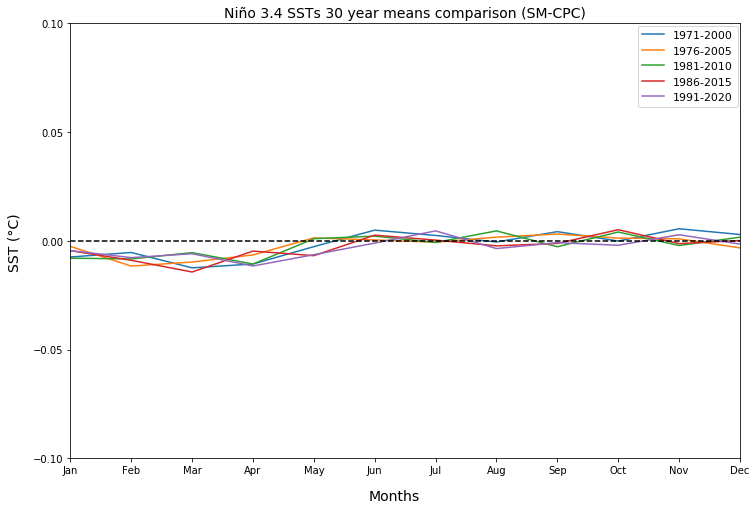

In [21]:
'''
   Plot the shifting ONI thirty year means starting at 1971-2000
   that I calculated and that CPC uses. Plot difference between
   my 30 year mean calculations and CPCs.

   This plot highlights my method to make ERSST SST values match
   the size of the Nino 3.4 box is not the exact method used by
   the CPC.
'''
#30 year means idx for my array of calculated 30 year mean values
#for each monthly 30 year period used (up to '91-'20)
idx_my_30yr_means = np.arange(1876,1996,5)
s_idx_cpc_means = int(np.where(idx_my_30yr_means == 1936)[0])
s_idx_means_compare = int(np.where(idx_my_30yr_means == 1971)[0])

#using these start indexes to evaluate the same 30 year means from each dataset
s_idx_my_30yr_means = s_idx_means_compare
s_idx_cpc_means_compare = s_idx_means_compare - s_idx_cpc_means

#compare 30 year means starting at 1976-2000 and ending at 1991-2020
thirty_yr_mean_diff = nino3pt4_30yr_means[s_idx_my_30yr_means:,:] - thirty_year_means_cpc[s_idx_cpc_means_compare:,:]

month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#legend
legend_info = ['1971-2000','1976-2005','1981-2010','1986-2015','1991-2020']
#create figure. Note: Make fig size larger than standard output for better data viewing
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
#set x-tick labels to be month_labels
ax.set_xlim([0,11])
ax.set_xticks(range(0,12))
ax.set_xticklabels(month_labels)
ax.set_ylim([-0.1,0.1])
ax.set_yticks(np.arange(-0.1,0.15,0.05))
# Set super labels for x and y axis
fig.text(0.06, 0.5, 'SST (°C)', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.text(0.5,0.06,'Months',ha='center',va='center',fontsize = 14)
for means in range(5):
    data_compare = ax.plot(np.arange(0,12,1),thirty_yr_mean_diff[means,:])

#add dashed line at zero for reference
x = np.arange(0,12,1)
y = np.zeros(12,)
ax.plot(x,y,'--',color='black')

#label title and add legend
plt.title('Niño 3.4 SSTs 30 year means comparison (SM-CPC)',fontsize = '14')
fig.legend([data_compare], labels=legend_info,
           bbox_to_anchor =(0.86, 0.85),fontsize = 11) 


In [22]:
'''
   Correlation of 30 years means I calculated for ONI
   vs. CPC's calculated ONI. Note: 30 year mean difference
   is less than 0.1°C across all seasons, which is has
   negligible impact on the strength of the relationship
   my ONI timeseries calculation has with CPC's 
   version of the ONI.
'''
print('Correlation SM/CPC 30 year means')
for means in range(5):
    c_means_oni = np.corrcoef(nino3pt4_30yr_means[means+s_idx_means_compare,:],
                              thirty_year_means_cpc[means+s_idx_cpc_means_compare,:])[0,1]
    print(legend_info[means])
    print(np.round(c_means_oni,3))

Correlation SM/CPC 30 year means
1971-2000
1.0
1976-2005
1.0
1981-2010
1.0
1986-2015
1.0
1991-2020
1.0


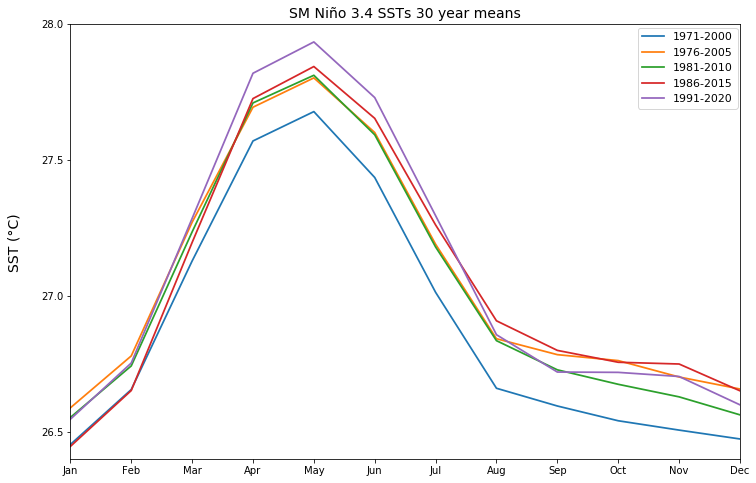

In [23]:
'''
   Plot thirty year means used to calculate ONI anomalies
   for same time periods since they are nearly identical to CPC's
   version. Indicates that SSTs in the Niño 3.4 region have 
   been warming.
'''
s_idx_my_30yr_means_plot = int(np.where(idx_my_30yr_means == 1971)[0])

#legend
legend_info = ['1971-2000','1976-2005','1981-2010','1986-2015','1991-2020']

#create figure. Note: Make fig size larger than standard output for better data viewing
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
#set x-tick labels to be month_labels
ax.set_xlim([0,11])
ax.set_xticks(range(0,12))
ax.set_xticklabels(month_labels)
ax.set_ylim([26.4,28])
ax.set_yticks(np.arange(26.5,28.5,0.5))
# Set super label for y axis
fig.text(0.06, 0.5, 'SST (°C)', ha='center', va='center', 
         rotation='vertical', fontsize = 14)

#colors = ['red','blue','green','orange','black']
for means in range(5):
    sm_means = ax.plot(np.arange(0,12,1),nino3pt4_30yr_means[means+s_idx_my_30yr_means_plot,:],
                      linewidth = 1.75)
    
plt.title('SM Niño 3.4 SSTs 30 year means',fontsize = '14')
fig.legend([sm_means], labels=legend_info,
           bbox_to_anchor =(0.86, 0.80),fontsize = 11)

In [24]:
'''Load in Niño 3 Index from Japanese Meteorological Agency (JMA)'''
#Data from Jan 1949 to November 2021 with ""99.9" values 
#for index values not available (at end of timeseries for
#December of 2021)
filename_nino3idx_jma = ENSOdir + "ENSO_indices\\nino3index_data_jma.csv"
nino3idx_df = pd.read_csv(filename_nino3idx_jma)

#get numeric values from csv file
nino3idx_datasheet = nino3idx_df.values
nino3idx_jma_ym = nino3idx_datasheet[:,1:] #exclude year labels from array
nino3idx_jma_vec_fill_vals = nino3idx_jma_ym.reshape(nino3idx_jma_ym.shape[0]*nino3idx_jma_ym.shape[1])
nino3idx_jma_vec = nino3idx_jma_vec_fill_vals[:-1]

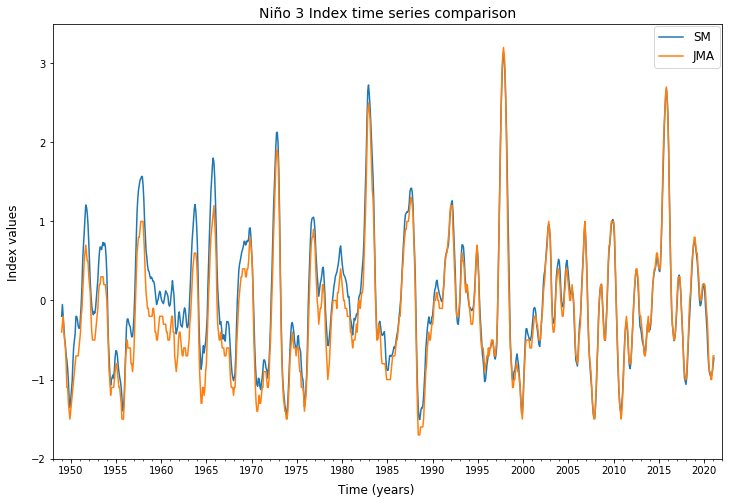

In [25]:
'''Plot timeseries of my Niño 3 index vs JMA's.'''

#indexing for plotting (last index value I calculated 
#for Nino 3 index is DJFMA 2021)

start_date_plot = int(np.where(SSTdtime_pd == '1949-01-01')[0])
end_date_plot = int(np.where(SSTdtime_pd == '2021-02-01')[0]) + 1
#axis using date timestamps
time_axis = SSTdtime_pd[start_date_plot:end_date_plot]

start_date_my_nino3 = int(np.where(SSTdtime_pd == '1892-01-01')[0])
start_ind_my_nino3 = start_date_plot - start_date_my_nino3
end_ind_my_nino3 = end_date_plot - start_date_my_nino3
sm_data = nino3index_vector[start_ind_my_nino3:end_ind_my_nino3]

start_date_jma_nino3 = int(np.where(SSTdtime_pd == '1949-01-01')[0])
start_ind_jma_nino3 = start_date_plot - start_date_jma_nino3
end_ind_jma_nino3 = end_date_plot - start_date_jma_nino3
jma_data = nino3idx_jma_vec[start_ind_jma_nino3:end_ind_jma_nino3]


#legend
legend_info = ['SM','JMA']
#create figure
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
sm_plot = ax.plot(time_axis,sm_data)
jma_plot = ax.plot(time_axis,jma_data)
plt.title('Niño 3 Index time series comparison',fontsize = '14')

ax.set_xlim([dt.date(1948, 1, 1), dt.date(2022, 1, 1)])
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(5)) #major tickmarks every 5 years
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) #minor tickmarks every year

ax.set_ylim([-2,3.5])
ax.set_yticks(np.arange(-2,4,1))

fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 12)
fig.legend([sm_data,cpc_data], labels=legend_info,
           bbox_to_anchor =(0.84, 0.84),fontsize = 12) 

In [26]:
print('Correlation my Niño 3 index and JMAs NDJFM 1949 to NDJFM 2021')
corr_plot = np.round(np.corrcoef(sm_data,jma_data)[0,1],3)
print(corr_plot)

Correlation my Niño 3 index and JMAs NDJFM 1949 to NDJFM 2021
0.975


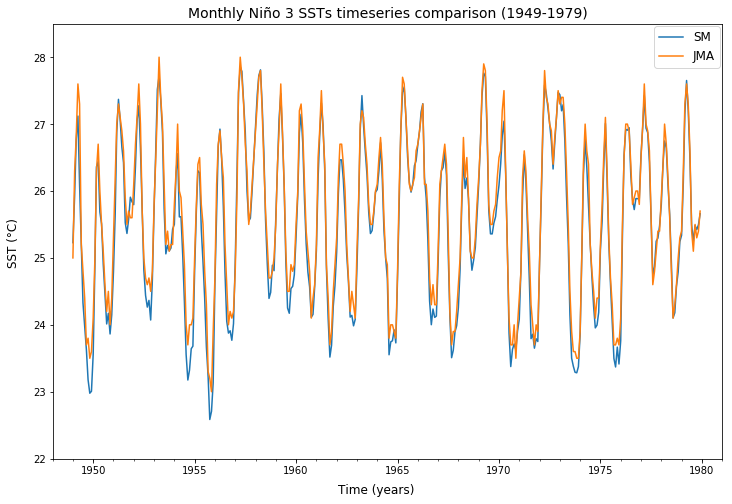

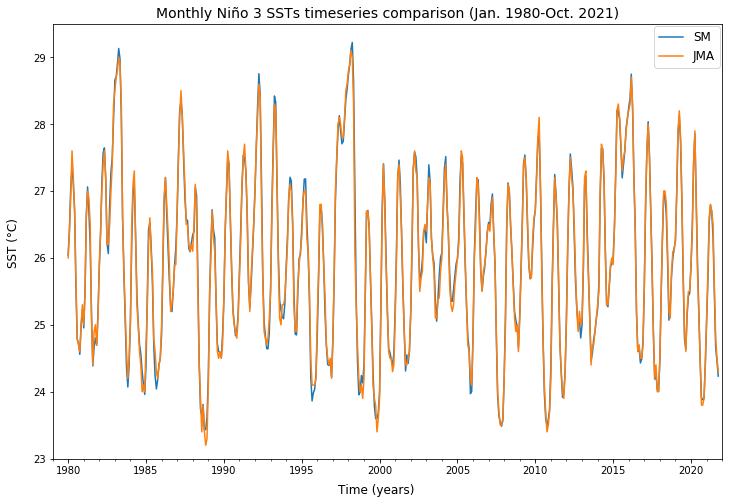

In [27]:
'''
   Japanese Meteorological Agency does not provide 30 year mean
   data they use to calculate Niño 3 index data, however they
   do provide monthly mean SST data. Use that to analyze the 
   apparent difference between my version and the JMA version.
   
   Monthly Niño 3 values I calculated do not quite match the 
   amplitude of JMA's in the first time period plotted but do for 
   the second. This further verifies, along with the 0.975 correlation 
   for the above plot, that my method to calculate the Niño 3 index 
   is correct.
'''

#Data from Jan 1948 to December 2021
filename = ENSOdir + "nino_box_info\\nino3_monthly_jma.csv"
nino3monthly_jma_df = pd.read_csv(filename)

#get numeric values from csv file
nino3monthly_jma_datasheet = nino3monthly_jma_df.values
nino3monthly_jma = nino3monthly_jma_datasheet[:,1:] #exclude year labels from array
nino3monthly_jma_vec = nino3monthly_jma.reshape(nino3monthly_jma.shape[0]*nino3monthly_jma.shape[1])
#exclude November and December of 2021 since ERSST data goes through
#Oct 2021
nino3monthly_jma_vec = nino3monthly_jma_vec[:-2]

'''Plot my Niño 3 monthly SSTs vs JMA's.'''

#indexing for plotting
start_ind_plot = int(np.where(SSTdtime_pd == '1949-01-01')[0])

start_ind_my_nino3 = start_ind_plot 
start_ind_jma_nino3 = 0

end_ind = int(np.where(SSTdtime_pd == '1979-12-01')[0]) + 1
end_ind_my_nino3 = end_ind
end_ind_jma_nino3 = end_ind -start_ind_plot

#axis using date timestamps
time_axis = SSTdtime_pd[start_ind_plot:end_ind]
#legend
legend_info = ['SM','JMA']

'''
   Plot for first time-period (where index values 
   are slightly off in above cells plot)
'''
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
sm_data = ax.plot(time_axis,nino3monthly[start_ind_my_nino3:end_ind_my_nino3])
jma_data = ax.plot(time_axis,nino3monthly_jma_vec[:end_ind_jma_nino3])
plt.title('Monthly Niño 3 SSTs timeseries comparison (1949-1979)',fontsize = '14')

ax.set_xlim([dt.date(1948, 1, 1), dt.date(1981, 1, 1)])
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(5)) #major tickmarks every 5 years
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) #minor tickmarks every year

ax.set_ylim([22,28.5])
ax.set_yticks(np.arange(22,29,1))

fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'SST (°C)', ha='center', va='center', rotation='vertical', fontsize = 12)
fig.legend([sm_data,cpc_data], labels=legend_info,
           bbox_to_anchor =(0.84, 0.84),fontsize = 12)

'''Plot for second time-period'''
start_ind_plot = int(np.where(SSTdtime_pd == '1980-01-01')[0])
start_ind_jma = int(np.where(SSTdtime_pd == '1949-01-01')[0])

start_ind_my_nino3 = start_ind_plot
start_ind_nino3_jma = start_ind_plot - start_ind_jma

#axis using date timestamps
time_axis = SSTdtime_pd[start_ind_plot:]

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
sm_data = ax.plot(time_axis,nino3monthly[start_ind_my_nino3:])
jma_data = ax.plot(time_axis,nino3monthly_jma_vec[start_ind_nino3_jma:])
plt.title('Monthly Niño 3 SSTs timeseries comparison (Jan. 1980-Oct. 2021)',fontsize = '14')

ax.set_xlim([dt.date(1979, 1, 1), dt.date(2022, 1, 1)])
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(5)) #major tickmarks every 5 years
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) #minor tickmarks every year

ax.set_ylim([23,29.5])
ax.set_yticks(np.arange(23,30,1))

fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'SST (°C)', ha='center', va='center', rotation='vertical', fontsize = 12)
fig.legend([sm_data,cpc_data], labels=legend_info,
           bbox_to_anchor =(0.84, 0.84),fontsize = 12)


In [28]:
'''
   Calculation of TNI using ERSST data
   
   Definition of TNI:
   Monthly Niño 1+2 anomalies - Niño 4 anomalies calculated
   using 1950-1979 means for both. Then, calculate the 5 
   month running means and divide the time series by the 
   standard deviation for the time period of 1950-1979.
   
   Source:
       Indices of Nino Evolution 
       Authors: K. Trenberth and D. Stepaniak
'''


'''
   Step 1: Calculate normalized Niño 1+2 and Niño 4 values.
'''

'''Calculate 30 year mean for the period 1950-1979'''
syeardata = SSTdtime_pd[0].year
syear_ind = 1950 - syeardata
endyear_ind = (1979 - syeardata) + 1

nino12_tni_30yr_means = np.zeros(12,)
nino4_tni_30yr_means = np.zeros(12,)
for month in range(12):
        nino12_tni_30yr_means[month] = np.mean(nino12monthly_ym[syear_ind:endyear_ind,month])
        nino4_tni_30yr_means[month] = np.mean(nino4monthly_ym[syear_ind:endyear_ind,month])
        
'''Calculate monthly anomalies for each Nino box'''

#arrays for storing calculations in for loop
nino12monthly_anom_tni = np.zeros((year_count_ersst,12))
nino4monthly_anom_tni = np.zeros((year_count_ersst,12))

for year in range(year_count_ersst):
    for month in range(12):
        nino12monthly_anom_tni[year,
                           month] = nino12monthly_ym[year,month] - nino12_tni_30yr_means[month]
        nino4monthly_anom_tni[year,
                           month] = nino4monthly_ym[year,month] - nino4_tni_30yr_means[month]

In [29]:
'''Find Niño 1+2 and Niño 4 anomaly values for
   rest of available data (2021 values)'''
#time bounds to use within for loop for rest of
#anomaly calculations
ind_j_2021 = int(np.where(SSTdtime_pd == '2021-01-01')[0])
ind_oct_2021 = int(np.where(SSTdtime_pd == '2021-10-01')[0]) + 1

nino12_anom_2021 = np.zeros(ind_oct_2021-ind_j_2021,)
nino4_anom_2021 = np.zeros(ind_oct_2021-ind_j_2021,)

#pre-set array to find months index needed in 30yr_means to calculate anomaly vals.
month_array = np.arange(0,11,1)

for month in range(ind_j_2021,ind_oct_2021):
    ind = month-ind_j_2021
    ind_month = month_array[ind]
    
    nino12_anom_2021[ind] = nino12monthly[month] - nino12_tni_30yr_means[ind_month]
    nino4_anom_2021[ind] = nino4monthly[month] - nino4_tni_30yr_means[ind_month]

In [30]:
'''Concatenate Niño box anomaly vectors'''
nino12_4_shape = nino12monthly_anom_tni.shape[0]*nino12monthly_anom_tni.shape[1]

nino12monthly_anom_full = np.zeros(len(SSTtime))
nino12monthly_anom_full[0:ind_j_2021] = nino12monthly_anom_tni.reshape(nino12_4_shape)
nino12monthly_anom_full[ind_j_2021:] = nino12_anom_2021

nino4monthly_anom_full = np.zeros(len(SSTtime))
nino4monthly_anom_full[0:ind_j_2021] = nino4monthly_anom_tni.reshape(nino12_4_shape)
nino4monthly_anom_full[ind_j_2021:] = nino4_anom_2021

In [31]:
'''Take monthly difference of Niño 1+2 and Niño 4'''
month_count_full = len(SSTtime)
tni_no_mean = np.zeros(month_count_full,)

for months in range(month_count_full):
    tni_no_mean[months] = nino12monthly_anom_full[months] - nino4monthly_anom_full[months]

In [32]:
'''Calculate TNI values from January 1855
   to August 2021 (NDJFM 1855-JJASO 2021)'''

s_ind_calc = int(np.where(SSTdtime_pd == '1855-01-01')[0])
end_ind_calc = int(np.where(SSTdtime_pd == '2021-08-01')[0]) + 1
month_count = end_ind_calc - s_ind_calc

tni_r_mean = np.zeros(month_count,)
for months in range(s_ind_calc,end_ind_calc):
    idx = months-12
    tni_r_mean[idx] = np.mean(tni_no_mean[months-2:months+3])
    
'''
   Standard deviation monthly TNI data 
   (no running mean) using base period 
   1950-1979
'''
j_1950 = int(np.where(SSTdtime_pd == '1950-01-01')[0])
idx_beg = j_1950- s_ind_calc
d_1979 = int(np.where(SSTdtime_pd == '1979-12-01')[0]) + 1
idx_end = d_1979- s_ind_calc
tni_std = np.std(tni_no_mean[j_1950:d_1979])

tni_r_mean_final= np.zeros(month_count,)
for months in range(month_count):
    tni_r_mean_final[months] = tni_r_mean[months]/tni_std
    
'''Method that takes monthly standard deviation of data'''
tni_std_mthly = np.zeros(12,)

for months in range(12):
    idx_calc = j_1950 + months
    tni_std_mthly[months] = np.std(tni_r_mean[idx_calc:d_1979:12])
    
mth_array = np.arange(0,12,1)
syear = 1855
endyear = 2021 + 1
repetitions = endyear - syear
idx_std_mth = np.tile(mth_array, (repetitions,1))
idx_std_vec = idx_std_mth.reshape(idx_std_mth.shape[0]*idx_std_mth.shape[1])

In [33]:
'''
   My calculated standard deviation for the TNI
   close to standard deviation Indices of El Niño
   Evolution paper listed.
   
   Check for accuracy of my re-created index
'''
print('Trenberth and Stepeniak listed standard deviation: 0.818')
print('My calculated standard deviation:', np.round(tni_std,3))

Trenberth and Stepeniak listed standard deviation: 0.818
My calculated standard deviation: 0.811


In [34]:
'''Load in TNI data from Physical Sciences Laboratory (PSL)'''

#Data from Jan 1948 to September 2021 with ""-99.9" values 
#for index values not available (at end of timeseries)
filename_tni_psl = ENSOdir + "ENSO_indices\\TNI_enso.csv"
tni_df = pd.read_csv(filename_tni_psl)

#get numeric values from csv file
tni_datasheet = tni_df.values
tni_psl_ym = tni_datasheet[:,1:] #exclude year labels from array
tni_psl_vec_fill_vals = tni_psl_ym.reshape(tni_psl_ym.shape[0]*tni_psl_ym.shape[1])
tni_psl_vec = tni_psl_vec_fill_vals[:-3]

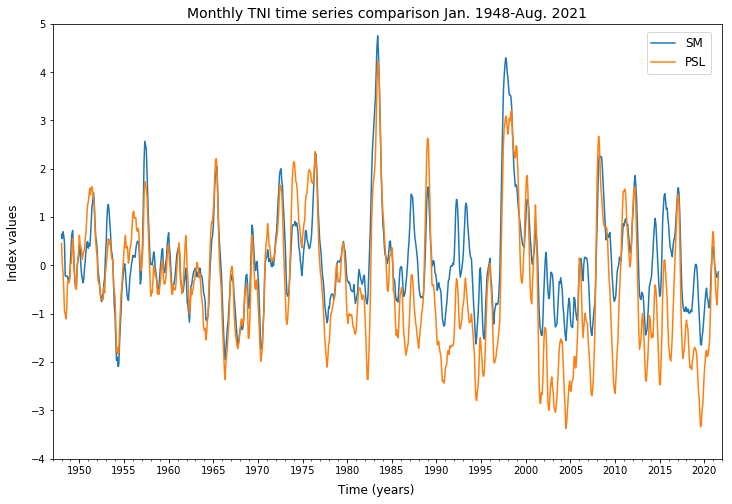

In [35]:
'''
   Plot my TNI vs. PSL TNI data for available overlapping
   time period.
'''
#indexing for plotting
start_date_plot = int(np.where(SSTdtime_pd == '1948-01-01')[0])
end_date_plot = int(np.where(SSTdtime_pd == '2021-08-01')[0]) + 1
#x-axis using date timestamps
time_axis = SSTdtime_pd[start_date_plot:end_date_plot]

start_date_tni_psl_data = int(np.where(SSTdtime_pd == '1948-01-01')[0])
start_ind_tni_plot = start_date_plot - start_date_tni_psl_data
end_ind_tni_plot = end_date_plot - start_date_tni_psl_data

tni_psl = tni_psl_vec[start_ind_tni_plot:end_ind_tni_plot]

start_date_my_tni = int(np.where(SSTdtime_pd == '1855-01-01')[0])
start_ind_my_tni_plot = start_date_plot - start_date_my_tni
end_ind_my_tni_plot = end_date_plot - start_date_my_tni

tni_sm = tni_r_mean_final[start_ind_my_tni_plot:end_ind_my_tni_plot]
#legend
legend_info = ['SM','PSL']

'''Plot data'''
for test in range(1):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    sm_data = ax.plot(time_axis,tni_sm)
    psl_data = ax.plot(time_axis,tni_psl)
    plt.title('Monthly TNI time series comparison Jan. 1948-Aug. 2021',fontsize = '14')

    ax.set_xlim([dt.date(1947, 1, 1), dt.date(2022, 1, 1)])
    ax.set_ylim([-4,5])
    ax.set_yticks(np.arange(-4,6,1))
    #Set major and minor dateticks 
    ax.xaxis.set_major_locator(mdates.YearLocator(5)) #major tickmarks every 5 years
    date_form = DateFormatter("%Y")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_minor_locator(mdates.YearLocator(1)) #minor tickmarks every year

    fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
    fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 12)
    fig.legend([sm_data,psl_data], labels=legend_info,
               bbox_to_anchor =(0.83, 0.83),fontsize = 12) 

In [36]:
print('Correlation my TNI and PSL TNI for Jan. 1950-Aug. 2021')
corr_sm_psl_tni = np.corrcoef(tni_sm,tni_psl)[0,1]
print(np.round(corr_sm_psl_tni,3))

Correlation my TNI and PSL TNI for Jan. 1950-Aug. 2021
0.835


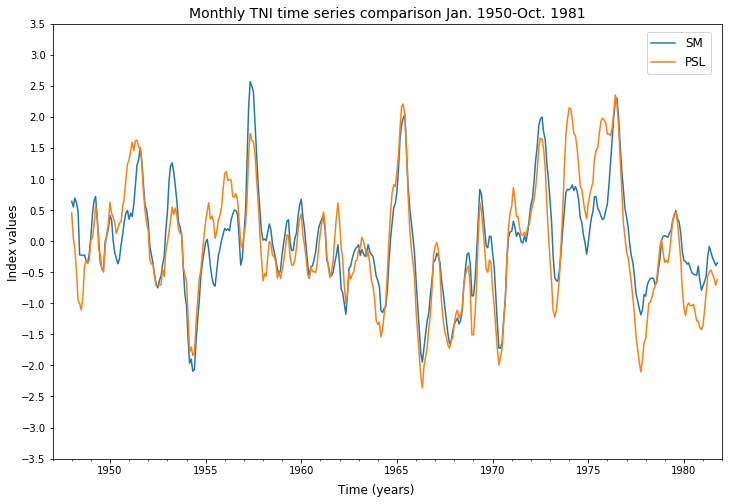

In [37]:
'''
   Trenberth and Stepaniak method to calculate the TNI splices datasets. 
   It uses HADISST data until October 1981 and the NCEP SST analysis
   for data from November 1981 to the present. This explains the lower
   correlation between my data and PSL data compared to the ONI and Niño 3
   index comparison.
  
   Plot data for the periods prior to October 1981 and following November 1981 
   to investigate the relationship between data prior to and after the discussed
   switch.
'''


'''
   1. Plot my TNI vs. PSL TNI for period of Jan. 1948 to October 1981, where
      they use HADISST data.
   
   As expected, my calculated TNI values more closely resemble the amplitude
   of index values when they use HADISST data, a reconstructed SST datset
   like the ERSST.
   '''

#indexing for plotting
start_date_plot = int(np.where(SSTdtime_pd == '1948-01-01')[0])
end_date_plot = int(np.where(SSTdtime_pd == '1981-10-01')[0]) + 1
#x-axis using date timestamps
time_axis = SSTdtime_pd[start_date_plot:end_date_plot]

start_date_tni_data= int(np.where(SSTdtime_pd == '1948-01-01')[0])
start_ind_tni_plot = start_date_plot - start_date_tni_data
end_ind_tni_plot = end_date_plot - start_date_tni_data

tni_psl2 = tni_psl_vec[start_ind_tni_plot:end_ind_tni_plot]

start_date_my_tni = int(np.where(SSTdtime_pd == '1855-01-01')[0])
start_ind_my_tni_plot = start_date_plot - start_date_my_tni
end_ind_my_tni_plot = end_date_plot - start_date_my_tni

tni_sm2 = tni_r_mean_final[start_ind_my_tni_plot:end_ind_my_tni_plot]

#legend
legend_info = ['SM','PSL']

'''Plot data'''
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

sm_data = ax.plot(time_axis,tni_sm2)
psl_data = ax.plot(time_axis,tni_psl2)

plt.title('Monthly TNI time series comparison Jan. 1950-Oct. 1981',fontsize = '14')

ax.set_xlim([dt.date(1947, 1, 1), dt.date(1982, 1, 1)])
ax.set_ylim([-3.5,3.5])
ax.set_yticks(np.arange(-3.5,4,0.5))
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(5)) #major tickmarks every 5 years
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) #minor tickmarks every year

fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 12)
fig.legend([sm_data,cpc_data], labels=legend_info,
           bbox_to_anchor =(0.83, 0.83),fontsize = 12) 

In [38]:
print('Correlation my TNI and PSL TNI for Jan. 1950- Nov. 1981')
corr_sm_psl_tni2 = np.corrcoef(tni_sm2,tni_psl2)[0,1]
print(np.round(corr_sm_psl_tni2,3))

Correlation my TNI and PSL TNI for Jan. 1950- Nov. 1981
0.867


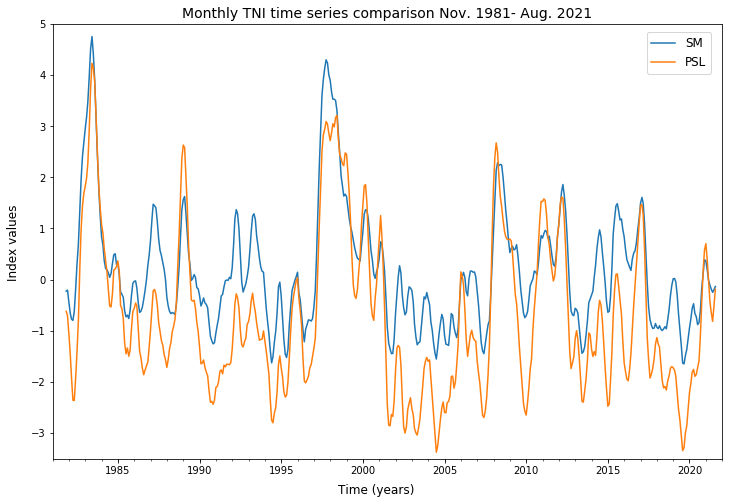

In [39]:
'''
   2. Plot my TNI vs. PSL TNI data Nov. 1981- Aug. 2021,
      when they switch to NCEP SST analysis dataset.
'''
#indexing for plotting
start_date_plot = int(np.where(SSTdtime_pd == '1981-11-01')[0])
end_date_plot = int(np.where(SSTdtime_pd == '2021-08-01')[0]) + 1
#x-axis using date timestamps
time_axis = SSTdtime_pd[start_date_plot:end_date_plot]

start_date_tni_data= int(np.where(SSTdtime_pd == '1948-01-01')[0])
start_ind_tni_plot = start_date_plot - start_date_tni_data
end_ind_tni_plot = end_date_plot - start_date_tni_data

tni_psl3 = tni_psl_vec[start_ind_tni_plot:end_ind_tni_plot]

start_date_my_tni = int(np.where(SSTdtime_pd == '1855-01-01')[0])
start_ind_my_tni_plot = start_date_plot - start_date_my_tni
end_ind_my_tni_plot = end_date_plot - start_date_my_tni

tni_sm3 = tni_r_mean_final[start_ind_my_tni_plot:end_ind_my_tni_plot]

#legend
legend_info = ['SM','PSL']

'''Plot data'''
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

sm_data = ax.plot(time_axis,tni_sm3)
cpc_data = ax.plot(time_axis,tni_psl3)

plt.title('Monthly TNI time series comparison Nov. 1981- Aug. 2021',fontsize = '14')

ax.set_xlim([dt.date(1981, 1, 1), dt.date(2022, 1, 1)])
ax.set_ylim([-3.5,5])
ax.set_yticks(np.arange(-3,6,1))
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(5)) #major tickmarks every 5 years
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) #minor tickmarks every year

fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 12)
fig.legend([sm_data,cpc_data], labels=legend_info,
           bbox_to_anchor =(0.83, 0.83),fontsize = 12)

In [40]:
print('Correlation my TNI and PSL TNI for Nov. 1980- Oct. 2021')
corr_sm_psl_tni3 = np.corrcoef(tni_sm3,tni_psl3)[0,1]
print(np.round(corr_sm_psl_tni3,3),'\n')

Correlation my TNI and PSL TNI for Nov. 1980- Oct. 2021
0.895 



Text(0.08, 0.5, 'Index values')

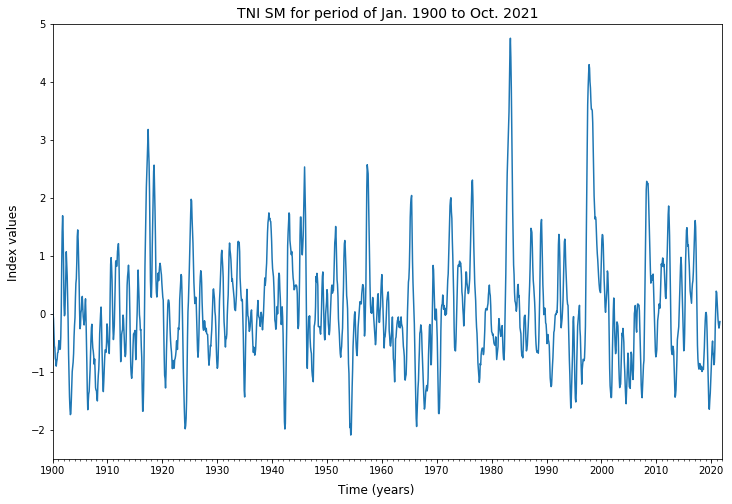

In [41]:
'''Plot my TNI for the period Jan. 1900-Oct. 2021'''

'''2. Plot my TNI vs. PSL TNI data Nov. 1981- Oct. 2020'''
#indexing for plotting
start_date_plot = int(np.where(SSTdtime_pd == '1900-01-01')[0])
end_date_plot = int(np.where(SSTdtime_pd == '2021-08-01')[0]) + 1
#x-axis using date timestamps
time_axis = SSTdtime_pd[start_date_plot:end_date_plot]

start_date_my_tni = int(np.where(SSTdtime_pd == '1855-01-01')[0])
start_ind_my_tni_plot = start_date_plot - start_date_my_tni
end_ind_my_tni_plot = end_date_plot - start_date_my_tni

tni_sm = tni_r_mean_final[start_ind_my_tni_plot:end_ind_my_tni_plot]

'''Plot data'''
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sm_data = ax.plot(time_axis,tni_sm)

plt.title('TNI SM for period of Jan. 1900 to Oct. 2021',fontsize = '14')

ax.set_xlim([dt.date(1900, 1, 1), dt.date(2022, 1, 1)])
#Set major and minor dateticks 
ax.xaxis.set_major_locator(mdates.YearLocator(10)) #major tickmarks every 5 years
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.YearLocator(1)) #minor tickmarks every year

ax.set_ylim([-2.5,5])
ax.set_yticks(np.arange(-2,6,1))

fig.text(0.5, 0.07, 'Time (years)', ha='center', va='center', fontsize = 12)
fig.text(0.08, 0.5, 'Index values', ha='center', va='center', rotation='vertical', fontsize = 12)

In [42]:
'''
   Save Niño 3.4 monthly, ONI, Niño 3 index, 
   and TNI as numpy files for later use
'''
import os
os.getcwd()

'C:\\Users\\Owner\\Documents\\python_dir\\python_scripts\\github_scripts'

In [43]:
rootpath = str("C:\\Users\\Owner")

dir_path_indices = rootpath + str("\\Documents\\python_dir\\ENSO\\ENSO_indices")
dir_path_sst_monthly = rootpath + str("\\Documents\\python_dir\\ENSO\\nino_box_info")

filename_indices_nino3 = dir_path_indices + str("\\nino3idx_ersst_j1892_f2021")
filename_indices_oni = dir_path_indices + str("\\oni_ersst_j1892_f2021")
filename_nino3pt4monthly = dir_path_sst_monthly + str("\\nino3pt4monthly_j1854_oct2021")
filename_tni = dir_path_indices + str("\\tni_ersst_j1855_aug2021")

np.save(filename_indices_nino3, nino3index_vector)
np.save(filename_indices_oni,oni_vector)
np.save(filename_nino3pt4monthly,nino3pt4monthly)
np.save(filename_tni,tni_r_mean_final)